In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import ast
import os

# Define Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [ ]:
# import required module
import os
# assign file
json_file = '/content/EternaBench_ChemMapping_Filtered_10Jul2021.json.zip'


data = pd.read_json(json_file)

dataset = RNA2D_Dataset(data)
print(len(dataset))
#print(data.head())

import pandas as pd

# Assuming 'data' is your dataframe loaded from the .json file

# Reset the index of the dataframe, which will assign a new index starting from 0
data_reset = data.reset_index(drop=True)

# If you want to save this new dataframe back to a .json file, you can do so as follows:
data_reset.to_json('reindexed_data.json', orient='records', indent=2)

# Display the first few rows of the new dataframe to verify
print(data_reset.head())

dataset = RNA2D_Dataset(data_reset)


14339
    Dataset        ID        MAPseq                         chemical  \
0  Round 00  769337-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
1  Round 00  766907-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
2  Round 00  766797-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
3  Round 00  766205-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
4  Round 00  766144-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   

          construct                  design_name  \
0  EteRNA Cloud Lab       d+m plots weaker again   
1  EteRNA Cloud Lab                Slalom take 1   
2  EteRNA Cloud Lab                        ZIG 1   
3  EteRNA Cloud Lab                    -9.3 kcal   
4  EteRNA Cloud Lab  Nuttier than a Snickers Bar   

                                              errors  \
0  [0.3181, 0.42210000000000003, 0.18230000000000...   
1  [0.24760000000000001, 0.4136, 0.1527, 0.206500...   
2  [0.35000000000000003, 0.4867, 0.22840000000000...   
3  [0.3116, 0.4144000000

# Define Model

In [ ]:
! pip install einops

In [ ]:
import sys

sys.path.append("/content/ribonanzanet2d-final/")

from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        config.dropout=0.3
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.dropout=nn.Dropout(0.0)
        self.ct_predictor=nn.Linear(64,1)

    def forward(self,src):

        #with torch.no_grad():
        _, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        pairwise_features=pairwise_features+pairwise_features.permute(0,2,1,3) #symmetrize

        output=self.ct_predictor(self.dropout(pairwise_features)) #predict

        return output.squeeze(-1)

In [ ]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/content/ribonanzanet2d-final/configs/pairwise.yaml")).cuda()

constructing 9 ConvTransformerEncoderLayers


In [ ]:
model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_location='cpu'))

<ipython-input-18-40bfaf6b5862>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/ribonanzanet2d-final/RibonanzaNet-SS.pt",map_loca

<All keys matched successfully>

In [ ]:
print(len(dataset))

14339


In [ ]:
dataset[0]

{'sequence': tensor([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 2, 3, 2, 1, 0, 3, 1, 0, 3, 0, 1, 2, 0, 3, 0, 0, 0, 0, 2,
         2, 3, 3, 2, 0, 3, 0, 2, 0, 2, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 3,
         2, 3, 1, 3, 3, 1, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])}

# Make predictions

In [ ]:
from tqdm import tqdm
import torch

test_preds = []
model.eval()

for i in tqdm(range(len(dataset))):
    # Access the item correctly for a PyTorch Dataset
    example = dataset[i]
    sequence = example['sequence'].cuda().unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).sigmoid().cpu().numpy())





  0%|          | 0/14339 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 14339/14339 [11:50<00:00, 20.18it/s]


In [ ]:
print(test_preds[0])

[[[4.1844929e-14 1.2397073e-13 5.9657405e-12 ... 1.2358697e-07
   2.3134473e-06 3.5345243e-04]
  [1.2397073e-13 3.1295902e-14 1.6928443e-13 ... 1.1316718e-06
   8.8668712e-06 9.0036490e-05]
  [5.9657405e-12 1.6928443e-13 3.4381660e-14 ... 3.1597931e-08
   5.3474598e-09 2.6101196e-08]
  ...
  [1.2358697e-07 1.1316718e-06 3.1597931e-08 ... 8.9895903e-16
   1.2191494e-17 6.4701230e-15]
  [2.3134473e-06 8.8668712e-06 5.3474598e-09 ... 1.2191494e-17
   2.7062180e-15 7.4790934e-15]
  [3.5345243e-04 9.0036490e-05 2.6101196e-08 ... 6.4701230e-15
   7.4790934e-15 1.2615207e-17]]]


In [ ]:
import pickle

# Path to save the file
save_path = '/content/test_preds_all_filtered.pkl'

# Save the list of lists to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(test_preds, f)

print(f"test_preds saved to {save_path}")


test_preds saved to /content/test_preds_all_filtered.pkl


In [ ]:
import pickle

# Path to load the file
load_path = '/content/test_preds_all_filtered.pkl'

# Load the list of lists from the pickle file
with open(load_path, 'rb') as f:
    x_dataset_preds = pickle.load(f)

print(f"x_dataset_preds loaded from {load_path}")


x_dataset_preds loaded from /content/test_preds_all_filtered.pkl


14339


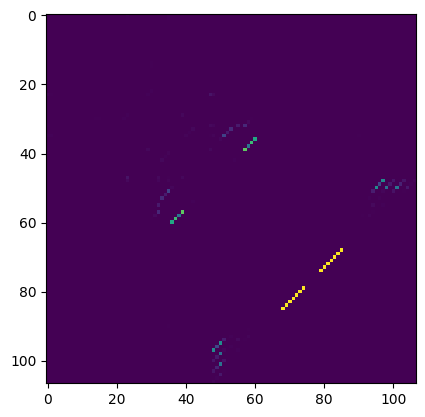

In [ ]:
# let's take a look at the predictions
import matplotlib.pyplot as plt
plt.imshow(x_dataset_preds[0][0])
print(len(x_dataset_preds))

### Convert bpp matrices to punp vectors.

In [ ]:

bpp_vector_list = []
for i in range(len(x_dataset_preds)):
    bpp_vector_list.append(1-np.sum((x_dataset_preds[i][0]), axis=0))




print(len(bpp_vector_list[0]))
len(bpp_vector_list)

107


14339

I want to truncate the punp vectors to len (79) and then save a .json file that has 'Dataset', 'filename', 'reactivity', and 'p_RibonanzaNet' columns. The 'Dataset' , 'reactivity', and 'filename' values are the same as in input dataframe stored under "data_reset". The 'p_RibonanzaNet' values are from the truncated bpp_vector_list. Both the 'reactivity' and bpp_vectors are trimmed to be a length of 79 values.

In [ ]:
assert len(data_reset) == len(bpp_vector_list)

In [ ]:
len(bpp_vector_list[1])
len(data_reset.iloc[12090]['reactivity'])

103

In [ ]:
data_reset['p_RibonanzaNet'] = bpp_vector_list
len(data_reset.iloc[12090]['p_RibonanzaNet'])

131

In [ ]:
data_reset.head()

Dataset        ID        MAPseq                         chemical  \
0  Round 00  769337-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
1  Round 00  766907-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
2  Round 00  766797-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
3  Round 00  766205-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   
4  Round 00  766144-1  [tag:RTB000]  [MgCl2:10mM, HEPES:50mM(pH8.0)]   

          construct                  design_name  \
0  EteRNA Cloud Lab       d+m plots weaker again   
1  EteRNA Cloud Lab                Slalom take 1   
2  EteRNA Cloud Lab                        ZIG 1   
3  EteRNA Cloud Lab                    -9.3 kcal   
4  EteRNA Cloud Lab  Nuttier than a Snickers Bar   

                                              errors  \
0  [0.3181, 0.42210000000000003, 0.18230000000000...   
1  [0.24760000000000001, 0.4136, 0.1527, 0.206500...   
2  [0.35000000000000003, 0.4867, 0.22840000000000...   
3  [0.3116, 0.41440000000000005, 0.1328, 0.1705, ...   
4  [0.4199, 0.6407, 0.32320000000000004, 0.249600...   

                                            filename modifier  \
0  ../data/preprocessing/raw_rdats/ETERNA_R00_000...    [1M7]   
1  ../data/preprocessing/raw_rdats/ETERNA_R00_000...    [1M7]   
2  ../data/preprocessing/raw_rdats/ETERNA_R00_000...    [1M7]   
3  ../data/preprocessing/raw_rdats/ETERNA_R00_000...    [1M7]   
4  ../data/preprocessing/raw_rdats/ETERNA_R00_000...    [1M7]   

   passed_CDHIT_filter  ...              project_name  \
0                 True  ...  Project : Thicker Zigzag   
1                 True  ...  Project : Thicker Zigzag   
2                 True  ...  Project : Thicker Zigzag   
3                 True  ...  Project : Thicker Zigzag   
4                 True  ...  Project : Thicker Zigzag   

                                          reactivity  \
0  [0.642, 1.4853, 0.16290000000000002, 0.4096, 0...   
1  [0.2707, 1.629, 0.1034, 0.29450000000000004, 0...   
2  [0.6619, 1.8323, 0.2554, 0.09280000000000001, ...   
3  [0.7497, 1.6132, 0.007, 0.1378, 0.198700000000...   
4  [0.4491, 1.6991, 0.21910000000000002, 0.0902, ...   

                                              seqpos  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            sequence signal_to_noise  \
0  GGAAAAAAAAAAAAAAAAAAAAACAAAAAGUGCAUCAUACGAUAAA...    medium:3.227   
1  GGAAAAAAAAAAAAAAAAAAAAACAAAAAGCUCGCAGUAGUACGAA...    medium:2.729   
2  GGAAAAAAAAAAAAAAAAAAAAACAAAAACGUGCGGCGACUAGGAA...    medium:2.295   
3  GGAAAAAAAAAAAAAAAAAAAAACAAAAAUAUCGCCCGAGUAUGAA...    medium:2.934   
4  GGAAAAAAAAAAAAAAAAAAAAACAAAAACACUACGGGAUGAGAAA...    medium:1.741   

                                           structure   tag temperature  \
0  .............................((((.((((.((((......  None       [24C]   
1  .............................((((.((((.((((......  None       [24C]   
2  .............................((((.((((.((((......  None       [24C]   
3  .............................((((.((((.((((......  None       [24C]   
4  .............................((((.((((.((((......  None       [24C]   

  EternaScore                                     p_RibonanzaNet  
0        68.0  [0.9557477, 0.9769194, 0.9979502, 0.9991846, 0...  
1        84.0  [0.9746439, 0.98744303, 0.99964845, 0.999532, ...  
2        86.7  [0.9621384, 0.9459274, 0.9999422, 0.9999056, 0...  
3        76.0  [0.97976536, 0.98974127, 0.99930835, 0.9992131...  
4        77.3  [0.97758186, 0.9921096, 0.99972826, 0.99981225...  

[5 rows x 21 columns]

In [ ]:
df = data_reset

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'column1' and 'column2' are the column names containing the 1D vectors

def trim_vectors(df, col1, col2):
    for index, row in df.iterrows():
        len_col1 = len(row[col1])
        len_col2 = len(row[col2])

        if len_col1 != len_col2:
            # Find the minimum length
            min_len = min(len_col1, len_col2)

            # Trim both columns to the minimum length
            df.at[index, col1] = row[col1][:min_len]
            df.at[index, col2] = row[col2][:min_len]

    return df

# Example usage
# df = pd.DataFrame({
#     'column1': [list(range(5)), list(range(10))],
#     'column2': [list(range(3)), list(range(8))]
# })

df = trim_vectors(df, 'reactivity', 'p_RibonanzaNet')


In [ ]:
df.to_json('/content/CM_RibonanzaNet.json', orient = 'records')

## You can zip the .json file above, and then use it in EternaBench ScoreChemMapping script (need to make some changes to the script) .
## once you have the _BOOTSTRAPS.json.zip file, you can use the CompileBootstrapping python script